<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 16 February 2023, with material from Peter Norvig and Chris Fonnesbeck</div>

# Bayesian statistical analysis and probabilistic programming

We now know how to use analytical parametric pdfs with known properties, and to match them with empirical data in order to zero in on the right parameters. It involves a bit of math (MOM), or a lot of math (MLE) for better estimates. The parameters are **point estimates**, the **data model** is **frequentist**, and we have little idea of the error we're making. The KS test does give us an idea, but how do we know where to draw the line on the p-value?

Today, we'll detail an **algorithmic approach** and a **Bayesian model** to do the same thing, but we'll also get a ***much better estimate of the error we're making*** in picking our parameters. Next week, we'll also *explore* that algorithm.

A frequentist model is described by an analytic function and its parameters. The method for solving for the model gives us what the most likely values for the parameters. MOM does this. MLE does this, even better. 

A **Bayesian method** yields parameters too, but it also yields **uncertainty** about those parameters. 

In other words, the model is described as a probability distribution, just like frequentist models, but the uncertainly in its parameters is *also* described as probability distributions. How wild is that?! The model is a pdf, and its parameters are *also* pdfs!

Run the cell below, we'll use it.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

### Bayesian vs Frequentist Statistics: *What's the difference?*

*Any* statistical inference scheme, Bayesian or otherwise, involves at least the following: 

1. Some **unknown quantities**, which we are interested in learning or predicting. These are called the **dependent variables**
2. Some **data** which have been observed, and hopefully contains information leading to the dependent variables. These are called the **independent variables**. Note that some of these may be **correlated** with themselves (linearly or not), so we should be able to throw the correlated ones and only use the ***really independent variables*** for predicting the dependent ones
3. One (or more) **models** that relate the independent variables to the dependent variables via a probablity distribution function (pdf). The pdf will yield **variates** that essentialy statistically ***look like the real data***. 

The model is the instrument you use to **learn** about the underlying process that yields the data. For example, you learn about the real world from the model that your parents build for you then teach you, before you leave home to build your own models. Machines build models to learn, too. They either learn them from the data, or we (humans) can also teach them the model, like parents to them! For example, we have meteorological models, which predict weather.

<br />
<center>
<img src="ipynb.images/robot-daddy.jpg" width="400" />
</center>

In a **Frequentist** world view, **data** observed is considered **random**, because it is the realization of random processes and hence will vary each time one goes to observe the system. Model **parameters** are considered **fixed**. A parameter's true value may be as of yet unknown, but it's fixed. You need to wait till you have *all the data* before you can use methods to evaluate it.

For example, Max Verstappen's probability of winning is fixed for the season. That's what you did in your homework. Jesus Christ is a central parameter in the Christian World Model. Christians will say the world order may be random because of human misgivings, but Jesus Christ and his compassion (the parameter) is fixed and steadfast.

In a frequentist world view, we take the winning scores of Lewis Hamilton from last season, and use these parameters as the ground truth for probabilities of wins this season. The wins may not match predictions, but that is because the world is **random**.

In a **Bayesian** world view,  *data* is considered **fixed**. Model parameters are **random** and treated as probability distributions. Model parameters *change all the time*, and as soon as you observe new evidence, you need to re-evaluate them!

For example, we need to reevaluate Max Verstappen's probability of winning *after every race*. I'm sur eyou felt that, too, when you did your homework. some Christians may postulate that world order is predetermined, however Jesus Christ's compassion may vary because.. *sometimes he gets exasperated by his followers*!

This religious analogy is *mine*, so if it's not very good, I apologize in advance! In my simple mind, it helps me understand what is *fixed*, and what is *variable*.

In a Bayesian world view, the world is not random: There is a perfect scientific explanation for everything. However, the probabilities for MV winning a race ***changes*** after every race. Sometimes he's on a winning streak, and other times on a losing streak.

## Bayes' Formula

While frequentist statistics uses different estimators for different problems, Bayes formula is the **only estimator** that Bayesians need to obtain estimates of unknown quantities. 

The equation expresses how our belief about the value of \\(\theta\\) (the parameter), as expressed by the **prior distribution** \\(P(\theta)\\) is reallocated following the observation of the data \\(y\\). 

For **discrete random variables**:

<div style="font-size: 120%;">  
\\[Pr(\theta\;|\;y) = \frac{Pr(\theta \cap y)}{Pr(y)} = \frac{Pr(y\;|\;\theta)Pr(\theta)}{\sum_\theta Pr(y\;|\;\theta)Pr(\theta)} \\]
</div>

The denominator is actually the expression in the numerator integrated over all possible discrete model parameters \\(\theta\\).

For **continuous random variables**, the denominator usually cannot be computed directly:

<div style="font-size: 120%;">  
\\[Pr(\theta\;|\;y) = \frac{Pr(y\;|\;\theta)Pr(\theta)}{\int Pr(y\;|\;\theta)Pr(\theta) d\theta}\\]
</div>

The denominator is the expression in the numerator integrated over all possible continuous model parameters \\(\theta\\)

The **intractability** of the integral in the denominator was the reason for the under-utilization of Bayesian methods by statisticians for many years. But with the advent of computers and clever algorithms like [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), this has changed!

## M&Ms
Remember this?

> The blue M&M was introduced in 1995.  Before then, the color mix in a bag of plain M&Ms was (30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan).  Afterward it was (24% Blue , 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown). 
A friend of mine has two bags of M&Ms, and he tells me that one is from 1994 and one from 1996.  He won't tell me which is which, but he gives me one M&M from each bag.  One is yellow and one is green.  What is the probability that the yellow M&M came from the 1994 bag? Well, the old M&M bags' yellow count was higher, so it must be higher, right? But how to count?

In a frequentist world view, you pick M&Ms the way we picked balls from our urns in our first lecture on probabilities. We just count all favorable outcomes and divide by all outcomes. No new experiment will change anything about that.

In a Bayesian world view, experiments change *everything*.

We are asked about the probability of an event (yellow_M&M94 + green_M&M96) given the evidence (M&M94 + M&M96 = {yellow, green}). The probability of the event is not readily available. However the probability of the evidence, given the event, is readily available!  

***Before*** (prior) we see the colors of the M&Ms, there are two hypotheses, `A` and `B`, both with equal probability:

    A: first M&M from 94 bag, second from 96 bag
    B: first M&M from 96 bag, second from 94 bag
    P(A) = P(B) = 0.5
    
***Then*** (posterior) we get some evidence:
    
    E: first M&M yellow, second green
    
We want to know the ***new*** (posterior) probability of hypothesis `A`, given the evidence:
    
    P(A | E)
    
That's not easy to calculate, except by enumerating the sample space (frequentist world view). But Bayes Theorem says:
    
    P(A | E) = P(E | A) * P(A) / P(E)
    
The quantities on the *right-hand-side* are easier to calculate:
    
    P(E | A) = 20/100 * 20/100 = 0.04
    P(E | B) = 10/100 * 14/100 = 0.014
    P(A)     = 0.5
    P(B)     = 0.5
    P(E)     = P(E | A) * P(A) + P(E | B) * P(B) 
             = 0.04     * 0.5  + 0.014    * 0.5   =   0.027
             
Where did the probability of the evidence P(E) formula come from?

There are two possibilities of getting the evidence: A and B, a *union* and so we sum their probabilities. The joint probability of the evidence *and* case A is a succession or *intersection*, so it must be a product of their probabilities: P(E|A).P(A). Likewise for the case B: P(E|B).P(B) 
    
And so here is how Bayes helps us get a final answer:
    
    P(A | E) = P(E | A) * P(A) / P(E) 
             = 0.04     * 0.5  / 0.027 
             = 0.7407407407
             
This is the **posterior** probability that A came from the '94 bag, given an event, which changed our world view that the probability was 0.5.

## In search of the model parameter $\theta \;$

Suppose we are given some data and we are told that there is a process that yields this data, and which we must try to model. So we must 
- 1: Pick the right pdf from the catalogue, and 
- 2: Determine the right $\theta$s for the data. 

More specifically, we are concerned with *beliefs* about what the $\theta$s might be: Rather than guessing the $\theta$s exactly, we talk about what $\theta$s are ***likely to be*** by assigning a probability distribution to them!

But these probability distributions are hidden from us. We see only see the data, and must ***go backwards*** to try and determine the $\theta$s to build the best possible model of our data. This problem is **difficult** because there is no one-to-one mapping from the data to the $\theta$s. 

In classical statistics we use the Method of Moments (MOM), and Maximum Likelihood Estimation (MLE), to get **point estimates** (not pdfs) for $\theta$.

In the Bayesian approach, we use **probabilistic programming** to solve this problem, with **Markov Chain Monte Carlo** (MCMC) methods and variational inference. 

## Example: Bayesian Model for 2 groups with continuous outcome

Let's do statistical inference for two groups (two statistics), with continuous random variables. 

We'll use the fictitious example from [Kruschke (2012)](http://www.indiana.edu/~kruschke/articles/KruschkeAJ2012.pdf) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "*smart drug*" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment (`drug`) and control (`placebo`) arms, respectively, and these are their post-trial IQs. An IQ between 90 and 110 is considered average; over 120, superior. Let's look at the histograms of our data, first thing you should always do.

Note that although our IQ data is integer type, our datasets here could easily be real-valued, and so we consider our random variable to be continuous.

Please plot histograms using `pd.concat([drug, placebo], ignore_index=True)`, and then `.hist('iq', by='group')` on the pandas dataframe.

array([<AxesSubplot:title={'center':'drug'}>,
       <AxesSubplot:title={'center':'placebo'}>], dtype=object)

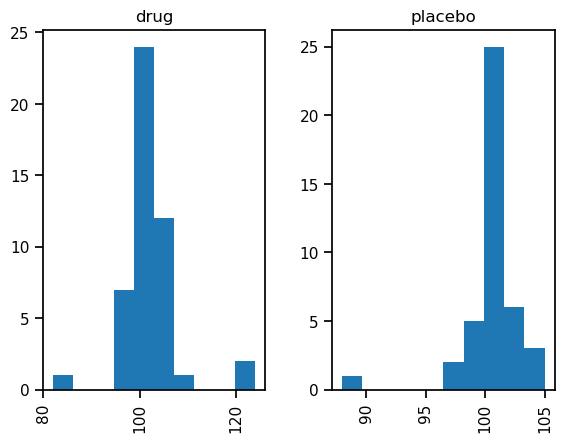

In [2]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group')


## The Student-T distribution

Hmm... there appears to be extreme ("outlier") values in the data (bins on the left and/or right that are distant from where most of the data lies, we say the data "*has wings*). That is a good indicator to pick a new pdf from our catalogue of all possible pdfs, called the [Student-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) distribution, to describe the distributions of the scores in each group. 

It was developed by [William Sealy Gosset](https://en.wikipedia.org/wiki/William_Sealy_Gosset) under the pseudonym `Student`. That's because William worked for Guiness, and Guiness was very worried about its secret Beer formula. Another researcher at Guinness had previously published a paper containing trade secrets of the Guinness brewery. To prevent further disclosure of confidential information, Guinness prohibited its employees from publishing any papers regardless of the contained information. So William published his results with a pseudonym. 

Another researcher, [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) introduced a new form of that statistic, denoted `t`. The t-form was adopted because it fit in with Fisher's theory of degrees of freedom. And so now we're stuck with the mysteriously-named `Student-t` distribution, which works great modeling histograms ***with outliers*** (like financial data!).

</br >
<center>
<img src="ipynb.images/guiness.jpg" width=200 />
</center>

This sampling distribution adds **robustness** to the analysis, as a `T distribution` is less sensitive to outlier observations, relative to a `normal` distribution. In other words, if you have ***a lot of outliers*** in your data and attempt to model your data with a normal distribution, your outliers will *skew* your model so that it does not fit the non-outlier data very well.

The **three-parameter** Student-t distribution allows for the specification of the following $\theta$s: A mean $\mu$, a precision (inverse-variance) $\lambda$, and a degrees-of-freedom parameter $\nu$:

$$f(x\;|\;\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
where $\Gamma$ denotes the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function), an extension of the factorial function (with its argument shifted down by 1) to real and complex numbers, and not to be confused with the (lower-case) maximum entropy [$\gamma$ distribution](https://en.wikipedia.org/wiki/Gamma_distribution) used to model rainfalls and insurance claims. This class will, if anything, teach you the greek alphabet!

The degrees-of-freedom parameter essentially specifies the "***normality***" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model will be specified as follows (since we seem to have outliers in our observations of IQ):

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups (both groups with similar outlier statistics). 

### Exercise
First:
```(python)
pip install pymc3
```

Now, draw 10,000 samples from a Student-T distribution (`StudentT` in PyMC3) with parameter `nu=3` and compare the distribution of these values to a similar number of draws from a `Normal` distribution with parameters `mu=0` and `sd=1`. The distribution is denoted `StudentT` in `pymc3`, while the normal distribution is denoted by `Normal`. So, `StudentT.dist(nu=3)` and `Normal.dist(0,1)`. Getting a random sampling of 10,000 datapoints can be achieved with `.random(size=10000)`. Plot with `seaborn` using `.distplot()`, from -10 to 10. You should find that the Student-T is more spread out and has a lower peak than the Gaussian. Import the Student-T distribution and the Normal distribution from pymc3: `from pymc3 import StudentT, Normal`. Then, draw 10,000 random variates from Student-T: `StudentT.dist(nu=3).random(size=10000)`, and 10,000 random variates from a gaussian: `Normal.dist(0,1).random(size=10000)`. Use `seagram` to plot both histograms on top of each other.

<div id="divCheckbox" style="display: none;">
from pymc3 import StudentT, Normal

t = StudentT.dist(nu=6).random(size=10000)
n = Normal.dist(0,1).random(size=10000)

sns.distplot(t, label='Student-T')
sns.distplot(n, label='Gaussian')
plt.legend()
plt.xlim(-10,10)
</div>

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-10.0, 10.0)

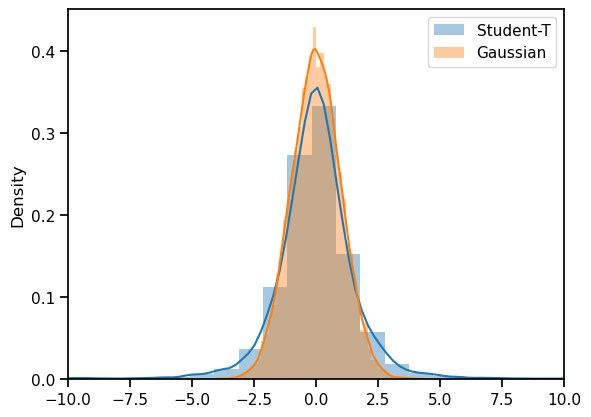

In [4]:
from pymc3 import StudentT, Normal

t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0,1).random(size=10000)

sns.distplot(t, label='Student-T')
sns.distplot(n, label='Gaussian')
plt.legend()
plt.xlim(-10,10)

Introducing PyMC3
-----

`PyMC3` is a Python library for programming Bayesian analysis; see [here](https://doi.org/10.7717/peerj-cs.55). It's a wonderful package. Looky [here](https://docs.pymc.io/) for its API and docs. It helps us solve tough inverse problems and extract a model from the data.

We will model our problem using PyMC3. This type of programming is called ***probabilistic programming***, and it is probabilistic in that we create probability models using programming variables as the model's components. Model components are first-class primitives within the PyMC3 framework. 

>   Another way of thinking about this: unlike a traditional program, which only runs in the forward direction, a probabilistic program runs in ***both*** forward and backward directions. It runs forward to compute consequences of assumptions it contains about the model, but also backward from the data to constrain possible explanations. In practice, many probabilistic programming systems will cleverly interleave forward and backward operations to efficiently home in on the best explanations.  - [Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013]( https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1)

PyMC3 used to rely on [**theano**](https://en.wikipedia.org/wiki/Theano_(software)), a Python library that allows one to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently, and which we will revisit when we focus on machine learning. Theano is the brainchild of [Yoshua Benjio](https://en.wikipedia.org/wiki/Yoshua_Bengio) of the University of Montreal's [MILA](https://mila.quebec/en/) laboratory. In my opinion, it's the most famous university lab associated to artificial neural networks and deep learning. It's pretty [well-funded](http://nouvelles.umontreal.ca/en/article/2017/09/15/facebook-invests-over-7m-u.s.-in-mila-and-ai-research-in-montreal/).

`theano` is now deprecated because other libraries like facebook's `Torch` and Google's `TensorFlow` now include the same features. Older PyMC3 versions still uses theano, but the newer versions don't, they use [**tensorflow**](https://en.wikipedia.org/wiki/TensorFlow) instead.

For probabilistic programming, you write a program in Python that builds expressions for Theano. You still have to declare variables $a,b,c$ and give their types $(int, int, int)$, build expressions for how to put those variables together $a^b + c$, and compile expression graphs to functions $Pow(a,b,c)$ in order to use them for computation. What theano builds in return is a super-fast callable object from a purely symbolic graph, optimizes the graph, and even compiles some or all of it into native machine instructions. More on Theano [here](http://www.deeplearning.net/software/theano/). 

For older theano versions of PyMC3, we needed to do this (don't do this if you're using a new version):
- On Windows, from the Start menu, search for and open `Anaconda Prompt`. On MacOS, open Launchpad, then click the Terminal icon. On Linux, open a Terminal window. Now in these windows, type `conda install -c mila-udem theano pygpu`. Don't try `!conda install theano` in a jupyter notebook code cell because it may fry your jupyter notebook's kernel. Wait until success. Then in that same terminal, type `conda install pymc3`. Wait until success.

PyMC3 code is easy to read. The only novel thing is the syntax. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as **probabilistic variables**. And the way we represent *continuous* probabilistic variables is with a probability density function (pdf): A **function**, not a **dictionary** anymore.

>**Note**: Do not confuse this/these function/s with the histogram of the dataset or the pdf that we will use to model it. That is a *different* function.

To figure out these functions, we will first assume they have a certain shape, which we will call the **prior shape**.

Then, we will run a simulation and try to approximate our data.

This will allow us to refine the prior shapes into **posterior shapes**, in accordance with Bayes' theorem.

### Picking our Priors

We have an idea about the means of our IQ data: The data for both drug and placebo group seem to be centered around IQ = 100.

So let's center the Student-T priors for $\mu$ at 100, using a Normal distribution, and a standard deviation that is wide enough to account for plausible deviations from this population mean:

$$\mu_k \sim N(100, 10^2)$$

- *Craaaaazy*, right? I'm modeling data using a **Student-T pdf model** with 3 parameters and I model the first parameter using a **normal distribution** (pdf).

Please do this below using:
```python
from pymc3 import Model, Uniform

with Model() as drug_model:
    μ_0 = Normal('μ_0', 100, sd=10)
    μ_1 = Normal('μ_1', 100, sd=10)
```

In [8]:
from pymc3 import Model, Uniform

with Model() as drug_model:
    μ_0 = Normal('μ_0', 100, sd=10)
    μ_1 = Normal('μ_1', 100, sd=10)

Now use a Uniform prior for the standard deviations $\sigma_k$ of the Student-T, with a lower bound of 0 and an upper bound of 20, here below:
```(python)
with drug_model:
    σ_0 = Uniform('σ_0', lower=0, upper=20)
    σ_1 = Uniform('σ_1', lower=0, upper=20)
```

- *Craaaazy*! I use a **uniform distribution** (pdf) to model the second parameter of the pdf-based model (standard deviation).

In [9]:
with drug_model:
    σ_0 = Uniform('σ_0', lower=0, upper=20)
    σ_1 = Uniform('σ_1', lower=0, upper=20)

For the degrees-of-freedom parameter $\nu$, use an exponential distribution with a mean of 30. 
```python
from pymc3 import Exponential
sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False);
```

- *Craaazy*! I use an **exponential distribution** to model the third parameter of my **student-T model**.

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


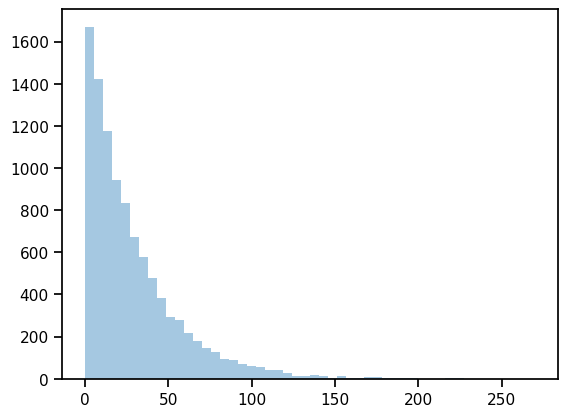

In [10]:
from pymc3 import Exponential
sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False);

This allocates ***high prior probability*** over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution:
```python
with drug_model:
    ν = Exponential('ν_minus_one', 1/29.) + 1
```

In [11]:
with drug_model:
    ν = Exponential('ν_minus_one', 1/29.) + 1

Now go ahead and model both datasets in `pymc3`:
```python
with drug_model:
    drug_like = StudentT('drug_like', nu=ν, mu=μ_1, lam=σ_1**2, observed=drug.iq)
    placebo_like = StudentT('placebo_like', nu=ν, mu=μ_0, lam=σ_0**2, observed=placebo.iq)
```

In [12]:
with drug_model:
    drug_like = StudentT('drug_like', nu=ν, mu=μ_1, lam=σ_1**2, observed=drug.iq)
    placebo_like = StudentT('placebo_like', nu=ν, mu=μ_0, lam=σ_0**2, observed=placebo.iq)

Turn your attention now to tracking the **posterior** ***quantities of interest***. Namely, calculate the difference in means between the drug and placebo groups: `diff_of_means = Deterministic('difference of means', μ_1 - μ_0)`. 

As a joint measure of the groups, also estimate the [**effect size**](https://en.wikipedia.org/wiki/Effect_size), which is the difference in means scaled by the pooled (square root of the squares) estimates of standard deviation: `Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))`. 

The effect size resembles the computation for a t-test statistic, with the critical difference that the t-test statistic includes a factor of ${\sqrt {n}}$. This means that for a given effect size, the significance level increases with the sample size. Unlike the t-test statistic, the effect size aims to estimate a population parameter and is not affected by the sample size (yay!). Effect size can be harder to interpret, since it is no longer in the same units as our data, but it is a function of all four estimated parameters.

We need to specify `Deterministic` because all PyMC3 variables are by default **probabilistic**, unless we set them to be **deterministic**.
```
from pymc3 import Deterministic
    
with drug_model:
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    effect_size = Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))
```

In [13]:
from pymc3 import Deterministic

with drug_model:
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    effect_size = Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

All right, all right, all right! Now our model is **fully specified** and we are ready to track our posteriors.

<br />
<center>
<img src="ipynb.images/allright.gif" width="600" />
All right, all right, all right
</center>

We will fit the model using [**variational inference**](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). This will estimate all our posterior distributions using an optimized approximation, and then draw 1,000 samples from it. Be *patient* now, we are running **probabilistic regressions**.
```python
from pymc3 import fit

with drug_model: 
    drug_trace = fit(random_seed=RANDOM_SEED).sample(1000)
```

In [14]:
from pymc3 import fit

with drug_model: 
    drug_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 264.22


***Waaaaait*** for the probabilistic computation to finish!

>**Note**: You *may* have to speify the extra argument (inside the `fit()` API): `cores = 1` if your laptop does not have the power to run all 4 cores (the *old* API analog was `njobs = 1`)

Now plot all your posterior distributions, throwing away the first 100 samples. You typically always throw away from 10% to 20% of your simulation samples, because they start off *wrong* before converging to the *right solution*:
```python
from pymc3 import plot_posterior

plot_posterior(drug_trace[100:], 
                varnames=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'],
                color='#87ceeb');
```

and in the next cell:
```python
plot_posterior(drug_trace[100:], 
          varnames=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');
```

if you have import errors on `plot_posterior`, chances are the APIs got moved to another library. So do this instead in an Anaconda prompt:
```(python)
pip install arviz
```

And then add this in the next cell:
```
from arviz import plot_posterior
```

Also, possible that `varnames` was renamed to `var_names`.

In any case, any error, please google the error. If not solution, let us know :-)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


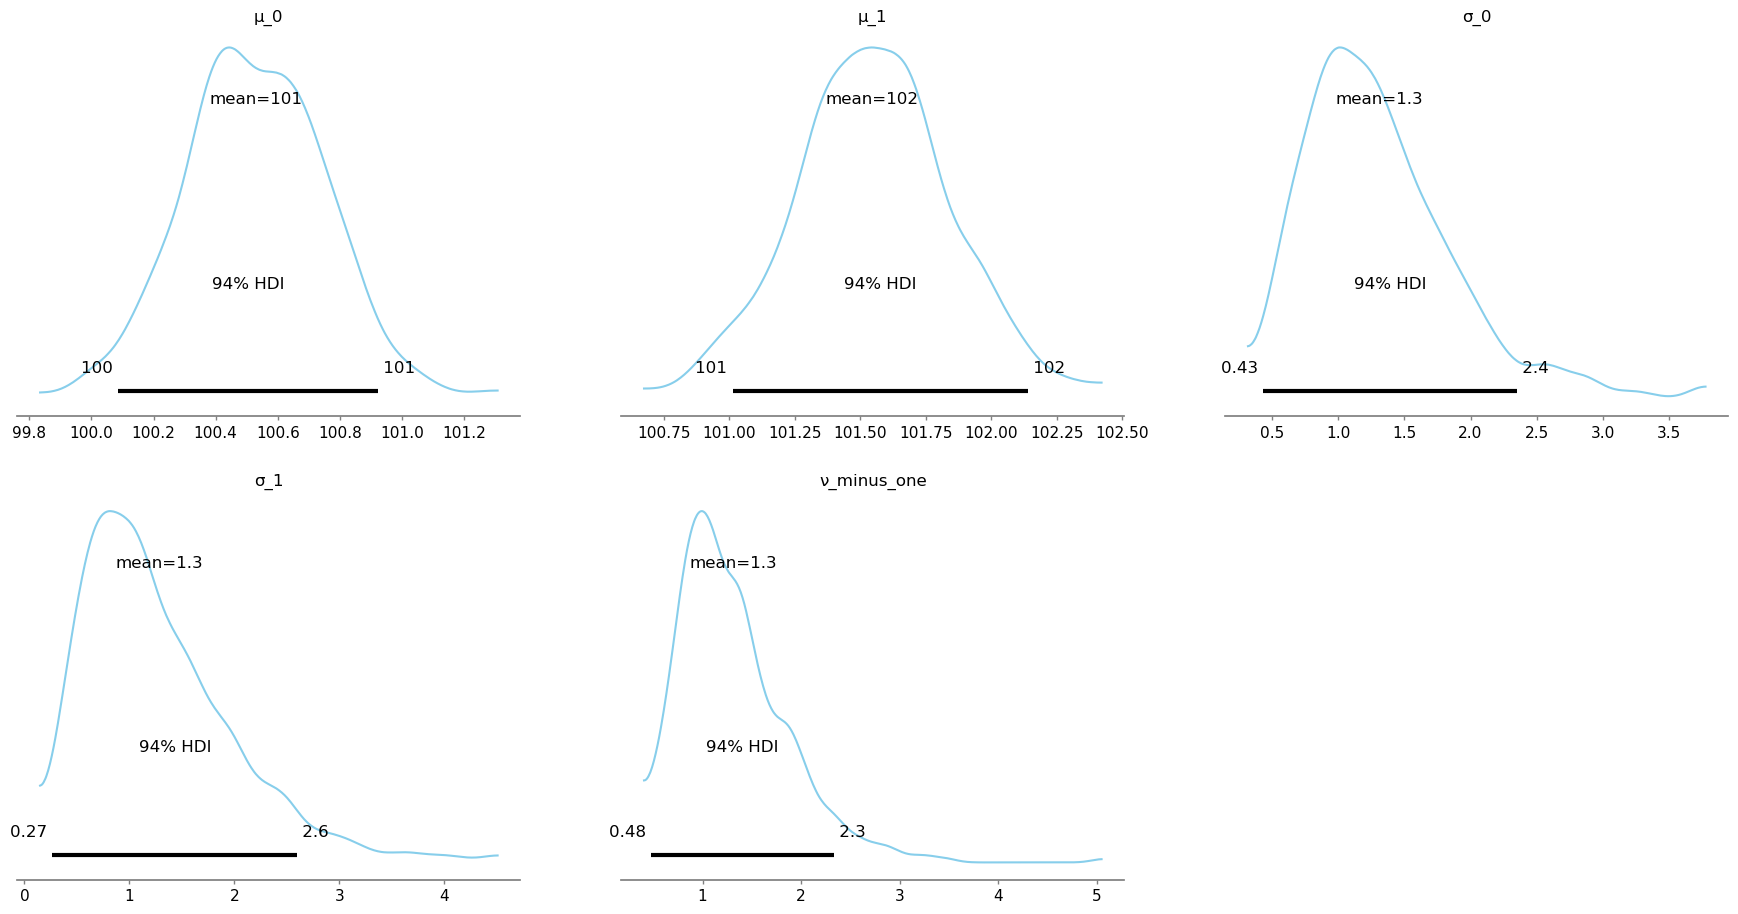

In [15]:
from arviz import plot_posterior

plot_posterior(drug_trace[100:], 
                var_names=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'],
                color='#87ceeb');



Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


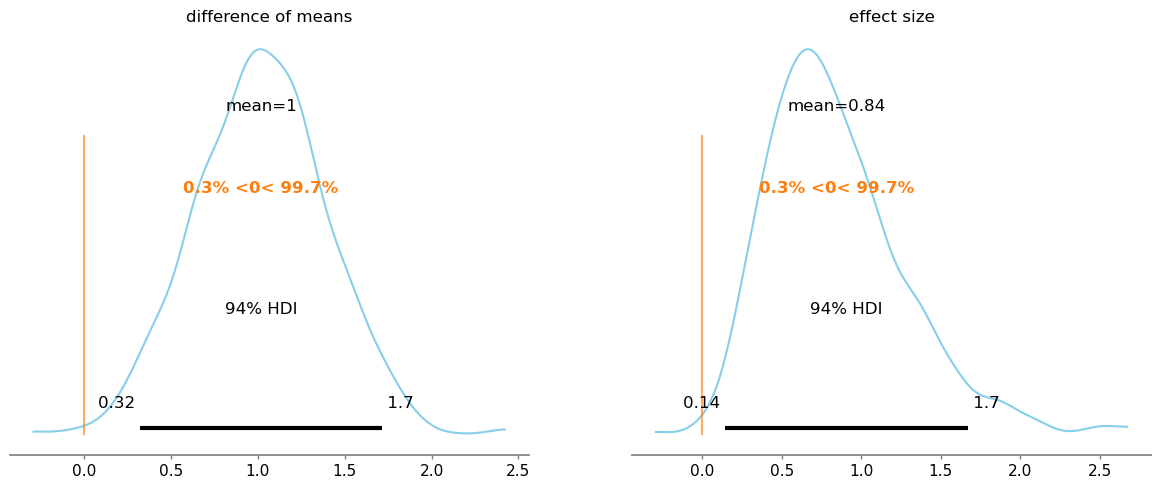

In [16]:

plot_posterior(drug_trace[100:], 
          var_names=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');

Now, *conclude* please..

<div style="display:none;">
- Conclusion: The posterior probability that the mean IQ of the subjects in the treatment group is greater than that of the placebo group is right of zero. That means that all the probability that the drug *worked* is concentrated beyond the null hypothesis (0), the effect of the drug is around 85%, and the most probable value in the difference between the drug group and the control group is a difference of 1 in the first parameter of the model assumed. So the IQ drug *worked*!
</div>

- Conclusion: The posterior probability ...

## Homework
- Repeat your experiment with MOM on a single-humped dataset but with MLE instead!
- Repeat your experiment with MOM on a single-humped dataset but with Bayesian simulation using PyMC3 instead!
- Which method is more correct, and which was the most fun?

## References and Resources

- Goodman, S. N. (1999). Toward evidence-based medical statistics. 1: The P value fallacy. Annals of Internal Medicine, 130(12), 995–1004. http://doi.org/10.7326/0003-4819-130-12-199906150-00008
- Johnson, D. (1999). The insignificance of statistical significance testing. Journal of Wildlife Management, 63(3), 763–772.
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian Data Analysis, Third Edition. CRC Press.
-  Norvig, Peter. 2009. [The Unreasonable Effectiveness of Data](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf).
- Salvatier, J, Wiecki TV, and Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. *PeerJ Computer Science* 2:e55 <https://doi.org/10.7717/peerj-cs.55>
- Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.